In this notebook, we will use a toy dataset to demonstrate Bayesian linear regression, and compare it to an ordinary least square fit (OLS) aka linear regression. 

This notebook is partly motivated by a series of awesome blogposts by Applied AI: http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/ 

In [2]:
import numpy as np
import pandas as pd
import patsy 
import statsmodels.api as sm
import pymc3 as pm
import pymc3.glm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sbn
%matplotlib inline

In [104]:
pd.options.display.max_columns = 20
np.set_printoptions(linewidth=150)

In [3]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)

# Data generation

In [18]:
def generateData(intercept=2, slope=3, noise=5, n_points=20):
    df = pd.DataFrame({'x': np.random.uniform(0, 10, size=n_points)})
    df['y'] = intercept + slope * df['x'] + np.random.np.random.normal(0, scale=noise, size=n_points)
    df = df.sort_values(['x'], ascending=True).reset_index(drop=True)
    return df

We will generate simple data points based on a linear relation with some random noise

In [140]:
intercept = 1
slope = 3
noise = 1
n_points = 25
data = generateData(intercept=intercept, slope=slope, noise=noise, n_points=n_points)

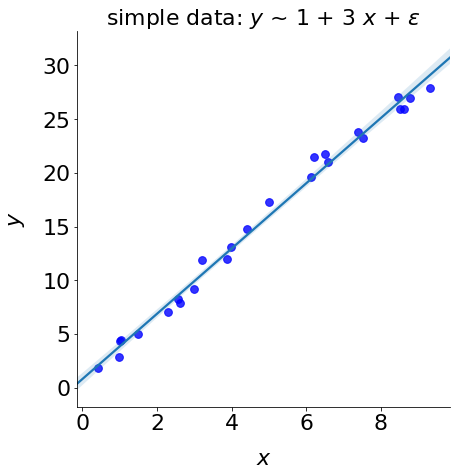

In [141]:
FONTSIZE = 22
g = sbn.lmplot(x='x', y='y', data=data, fit_reg=True, 
               size=6, scatter_kws={'alpha':0.8, 's':60, 'color': 'b'})

_ = g.axes.flat[0].set_xlabel(r'$x$', fontsize=FONTSIZE, labelpad=15)
_ = g.axes.flat[0].set_ylabel(r'$y$', fontsize=FONTSIZE, labelpad=15)
g.axes.flat[0].set_title(r'simple data: $y$ ~ {0:} + {1:} $x$ + $\epsilon$'.format(intercept, slope), 
                         fontsize=FONTSIZE)
adjustAxeProperties(g.axes.flat[0], FONTSIZE, 0, FONTSIZE, 0)


# Linear regression (OLS)

In [142]:
formula = 'y ~ x'
(y, X) = patsy.dmatrices(formula, data, return_type='dataframe')
lin_reg = sm.OLS(y, X).fit()

In [143]:
lin_reg.params

Intercept    0.829190
x            3.035689
dtype: float64

In [144]:
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2557.
Date:                Tue, 28 Nov 2017   Prob (F-statistic):           4.41e-25
Time:                        21:24:28   Log-Likelihood:                -30.255
No. Observations:                  25   AIC:                             64.51
Df Residuals:                      23   BIC:                             66.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8292      0.334      2.483      0.021       0.138       1.520
x              3.0357      0.060     50.565      0.000       2.911       3.160
==============================================================================
Omnibus:                        1.787   Durbin-Watson:                   1.344
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.564
Skew:                           0.504   Prob(JB):                        0.458
Kurtosis:                       2.302   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Bayesian linear regression

In Bayesian regression, we assume some prior distribution of our parameters $\beta$, and then based on the observe data $D$, we update our belief to form the posterior:

$
P(\beta|D) = \dfrac{P(D|\beta) P(\beta)}{P(D)}
$

In this example, we assume that the prior $P(\beta)$ is a Gaussian:

$P(\beta) = \mathcal{N}(0, \mathbf{I}\sigma_0^2)$, 

and the likelihood is also a Gaussian:

$P(D|\beta) = \mathcal{N}(y|X \beta, \sigma^2)$

In [145]:
BURN_IN_STEPS = 2000
MCMC_STEPS = 4000
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula=formula, data=data, family='normal')
    start_MAP = pm.find_MAP()
    trace = pm.sample(BURN_IN_STEPS+MCMC_STEPS, start=start_MAP, step=pm.NUTS())
    trace = trace[BURN_IN_STEPS:]
    

logp = -40.852, ||grad|| = 4.9128: 100%|██████████| 36/36 [00:00<00:00, 2087.56it/s]  
100%|██████████| 6500/6500 [00:08<00:00, 757.55it/s]


In [146]:
pm_summary_df = pm.df_summary(trace)

In [147]:
pm_summary_df

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,0.810019,0.347509,0.009181,0.150782,1.490119
x,3.039207,0.062647,0.001646,2.910353,3.159146
sd,0.896041,0.138106,0.002871,0.632082,1.149115


# Bayesian versus OLS

Let's compare the results we obtained from OLS and Bayesian linear regression.

As shown below, they are pretty consistent.

In [148]:
compare_df = pd.concat([pm_summary_df['mean'], lin_reg.params], axis=1)
compare_df.columns = ['Bayesian', 'OLS']
compare_df.loc[['Intercept', 'x', 'sd']]

,Bayesian,OLS
Intercept,0.810019,0.829190
x,3.039207,3.035689
sd,0.896041,NaN


# MCMC plots

Let's actually plot the MCMC trace and the OLS parameters to compare.

In the trace plots below, blue lines are from MCMC samplings, which form the posterior distribution. The red lines are from the OLS fit, which is basically the maximum likelihood estimate (MLE).

With sufficient amount of data, the means of MCMC posterior should be very close to the MLE.

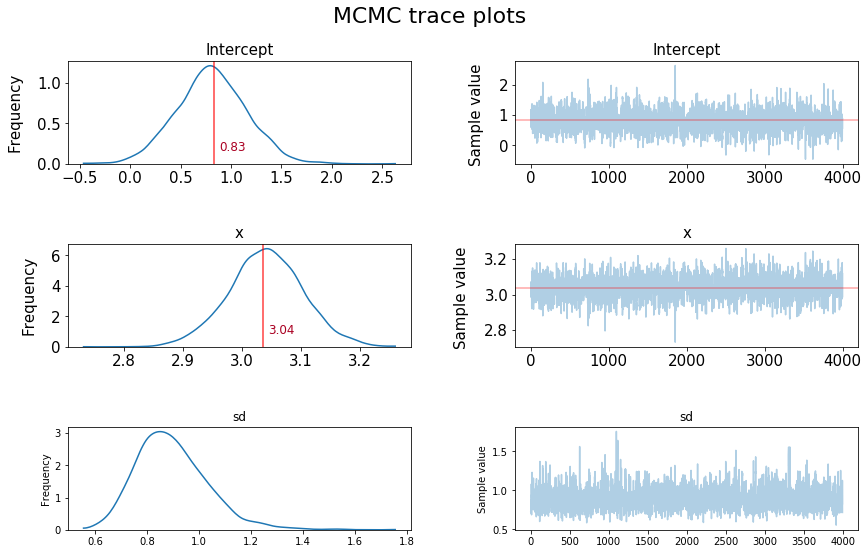

In [149]:
plt.close('all')

nrows = len(pm_summary_df)
varnames = pm_summary_df.index.tolist()
axes = pm.traceplot(trace, varnames=varnames, figsize=(12, nrows*2.5),
                    lines=lin_reg.params.to_dict())

for i, coeff in enumerate(lin_reg.params):
    axes[i, 0].annotate('{0:.2f}'.format(coeff), xy=(coeff, 0), xytext=(5, 10),
                        xycoords='data', textcoords='offset points', rotation=0,
                        va='bottom', fontsize='large', color='#AA0022')
    
    adjustAxeProperties(axes[i, 0], 15, 0, 15, 0)    
    axes[i, 0].set_xlabel(' ', fontsize=0, labelpad=5)
    axes[i, 0].set_ylabel('Frequency', fontsize=15, labelpad=15)
    axes[i, 0].set_title(varnames[i], fontsize=15)
    
    adjustAxeProperties(axes[i, 1], 15, 0, 15, 0)    
    axes[i, 1].set_xlabel(' ', fontsize=0, labelpad=5)
    axes[i, 1].set_ylabel('Sample value ', fontsize=15, labelpad=15)
    axes[i, 1].set_xticks(np.linspace(0, MCMC_STEPS, 5))
    axes[i, 1].set_title(varnames[i], fontsize=15)

    
st = plt.suptitle('MCMC trace plots', fontsize=22)
plt.tight_layout(pad=0, w_pad=4, h_pad=4)
st.set_y(1.0)
plt.subplots_adjust(top=0.9)
plt.savefig('Bayesian_regression_simple_data.png', bbox_inches='tight')

# Posterior distributions

Remember that in Bayesian approach, we are not just fitting a line, we are actually fitting a posterior distribution. 

So let's actually see what does this posterior look like and how does it compare to the observed data points.


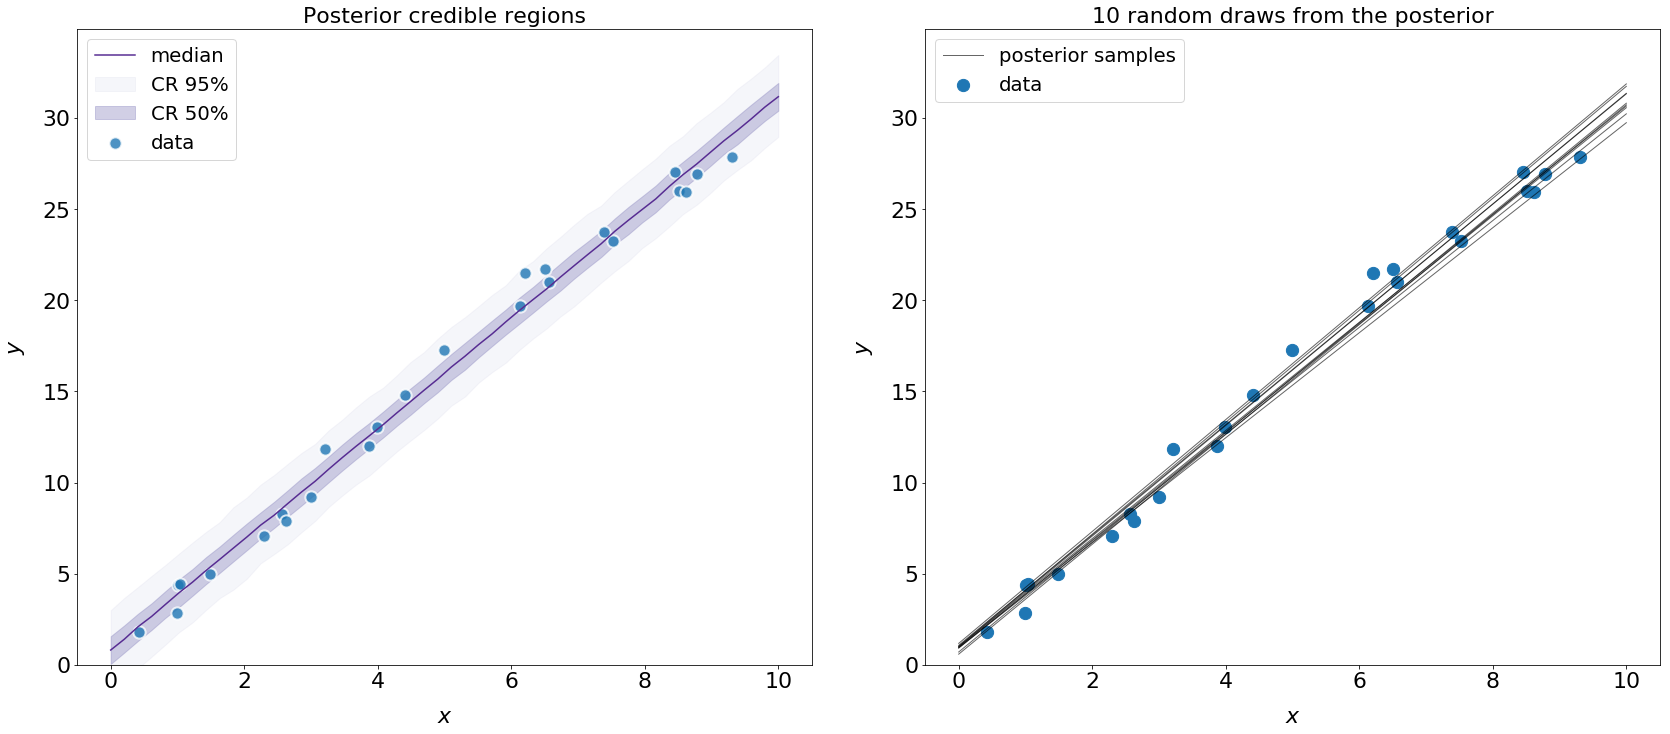

In [151]:
FONTSIZE = 22
plt.close('all')
fig = plt.figure(figsize=(23, 10))   # horizontal, vertical
gs = matplotlib.gridspec.GridSpec(1, 2)  # vertical, horizontal

n_evaluation_points = 50
x_values = np.linspace(0, 10, n_evaluation_points)


# Plot the credible regrions of the posterior distribution
ax = plt.subplot(gs[0, 0])
trace_beta = pm.trace_to_dataframe(trace)[['Intercept', 'x']]
trace_sigma = pm.trace_to_dataframe(trace)['sd']

X = np.ones((n_evaluation_points, 2))
X[:, 1] = x_values
mu = np.dot(X, trace_beta.T)
sigma = trace_sigma.values
posterior = np.random.normal(mu, sd)

credible_regions = pd.DataFrame(np.percentile(posterior, [2.5, 25, 50, 75, 97.5], axis=1).T,
                                columns=['02.5','25.0','50.0','75.0','97.5'])
credible_regions['x'] = x_values

pal = sbn.color_palette('Purples')
ax.fill_between(credible_regions['x'], credible_regions['02.5'], credible_regions['97.5'], alpha=0.2, 
                color=pal[1], label='CR 95%')
ax.fill_between(credible_regions['x'], credible_regions['25.0'], credible_regions['75.0'], alpha=0.4, 
                color=pal[3], label='CR 50%')
ax.plot(credible_regions['x'], credible_regions['50.0'], color=pal[5], label='median')

sbn.regplot(x='x', y='y', data=data, fit_reg=False, ax=ax, label='data',
            scatter_kws={'alpha':0.8, 's':150, 'lw':2,'edgecolor':'w'})

ax.set_xlabel(r'$x$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel(r'$y$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylim(0, 34.9)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc=2, fontsize=FONTSIZE*0.9)
ax.set_title('Posterior credible regions', fontsize=FONTSIZE)


# Draw 10 random samples for the posterior
ax = plt.subplot(gs[0, 1])
idx_list = np.random.choice(len(trace), size=10, replace=False)
ax.scatter(data['x'], data['y'], s=150, label='data')
for i, idx in enumerate(idx_list):    
    y_values = trace[i]['Intercept'] + trace[idx]['x'] * x_values
    if i == 0:
        ax.plot(x_values, y_values, color='k', lw=1, alpha=0.6, label='posterior samples')
    else:
        ax.plot(x_values, y_values, color='k', lw=1, alpha=0.6)
ax.set_title('10 random draws from the posterior', fontsize=FONTSIZE)    
ax.set_xlabel(r'$x$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel(r'$y$', fontsize=FONTSIZE, labelpad=15)
ax.set_ylim(0, 34.9)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
ax.legend(loc=2, fontsize=FONTSIZE*0.9)


plt.tight_layout(pad=0, w_pad=4.0, h_pad=1.0)


Left: Overlay of the data points with the 50% credible, 95% credible, and the median of the posterior distributions.

Right: Overlay of the data points with 10 random draws from the posterior distribution. A $\textit{random draw}$ corresponds to a pair of (Intercept, slope), which allows us to draw a line. So, 10 random draws correspond to 10 lines.

Full credit to Jonathan Sedar at Applied AI (http://blog.applied.ai/bayesian-inference-with-pymc3-part-1/) for the plotting style on the left